# 제 6회 L'Point BigData Competition

##### 부제: Audience Targeting

### 1. 데이터 이해 및 크롤링

#### 1.1 데이터 이해 및 가설 설정

* 온라인 행동 정보, 거래 정보, 고객의 Demo정보, 상품 분류 정보의 4가지 데이터 셋 제공  
* 구매기록이 없는 고객에 대해서 Demo정보가 모두 Null값이었기 때문에 이후 분석에서 사용하지 않음  
* 검색기록이 곧 구매기록으로 이어질 것이라는 가설을 설정하고 온라인 행동 정보 데이터를 활용하여 가설의 타당성에 대해 파악하기로 결정

#### 1.2 크롤링(Crawling papago.py)

검색기록의 경우 한글인 반면, 구매기록의 제품의 경우 영어로 표기되어 있어 네이버 파파고 크롤링을 통해 구매기록을 한글로 변환

### 2. 가설 검증(Word2Vec)

In [ ]:
wv = Word2Vec(size=20,
              min_count=1,
              workers=4,
              sentences=[simple_preprocess(p) for p in y_text]
             )

min_count: 한번 이상 나타난  
sentences: 구매자의 검색/구매 키워드에 대해   
size: 20차원의 행렬로 재구성하여 각 키워드에 대한 좌표 생성

In [26]:
wv.wv.most_similar('커피')

[('부드러운', 0.9352742433547974),
 ('음료수', 0.9261784553527832),
 ('콜라', 0.919846773147583),
 ('음료', 0.9096559286117554),
 ('믹스', 0.8925400972366333),
 ('믹스커피', 0.8851101994514465),
 ('스틱', 0.8782070279121399),
 ('주머니', 0.8757156133651733),
 ('과일주스', 0.8729631900787354),
 ('사과주', 0.8726745843887329)]

구매기록이 있는 고객 데이터와 gensim의 Word2Vec을 활용하여 검색기록과 구매기록 간의 관계를 확인
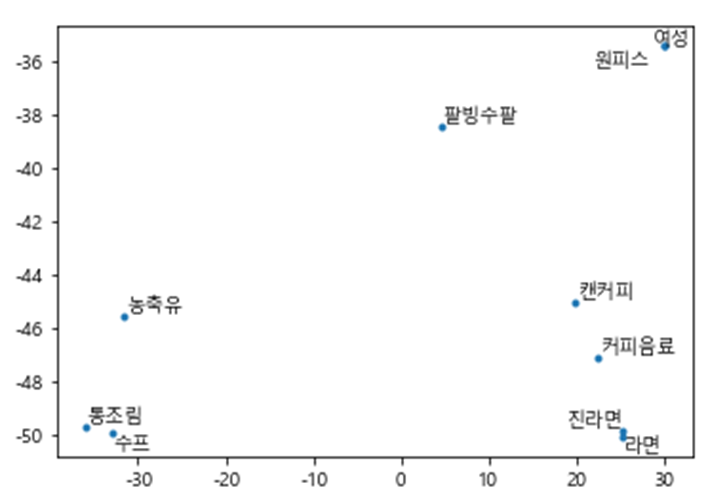  
* 위 그림과 같이 각각의 검색 키워드들이 구매 카테고리와 의미상으로 가깝게 배치있다. 즉, 검색이 구매로 연결되는 가설은 성립한다고 판단

### 3. 잠재고객과 유사한 구매고객 추출

#### 3.1 고객에 대한 대표 벡터 생성

In [31]:
y_wv = []
for i in range(0, len(pre_y_text)):
    a =  pre_y_text[i]
    b = np.zeros(20)
    for j in range(0, len(a)):
        b = b + wv.wv[a[j]]
        c = b/len(a)
    y_wv.append(c)

pre_y_text: 각 고객의 검색/구매기록을 통해  
b: 각 키워드 행렬 원소 값을 더하고  
c: 평균값으로 만들어 주면 각 고객에 대한 대표 벡터가 생성됨  
* Word2Vec을 구축할 때 sentence를 한줄마다 한 고객의 검색/구매 기록이 들어가도록 했기 때문에 카테고리가 다르더라도 한 고객이 기록한 키워드의 좌표는 고객을 중심으로 모여있다. 이를 통해 고객의 대표 벡터를 추정

#### 3.2 코사인 유사도 계산

In [ ]:
index_t = []
index_c = []
for i in tqdm.tqdm_notebook(range(0, len(n_wv))):
    a = i
    cos = []
    for j in range(0, len(y_wv)):
        cos.append(cosine_similarity(n_wv[a].reshape(1,-1),y_wv[j].reshape(1,-1)))
        
    cos_df = pd.DataFrame({
        'cos_sim': cos
    }).sort_values(by='cos_sim', ascending = False).reset_index()
    
    sim_c = cos_df.iloc[1,0]
    index_c.append(sim_c)
    
    b = clean_y_t[sim_c]
    sim_t = new_product.query('kor_clac_nm3 in @b').iloc[:,1].values
    index_t.append(sim_t)

n_wv: 잠재고객의 대표 벡터를  
y_wv: 구매고객의 대표 벡터와  
cos: 코사인 유사도를 계산하고  
sim_c: 각 잠재고객과 가장 유사한 구매고객의 id를 추출하여 index_c에 저장  
sim_t: 그리고 해당 구매고객의 제품 카테고리를 index_t에 저장

In [ ]:
final = pd.DataFrame({
    'clnt_id': n_df.clnt_id.unique(),
    'trans': index_t
    'sim_id': index_c
})

### 4. 추천시스템 구축

#### 4.1 co-occurence matrix 제작

제품의 구매에 따른 평점에 대한 데이터가 없었기 때문에 동시 출현 횟수를 통한 추천으로 진행

In [ ]:
user_item_hits = sparse.coo_matrix((np.repeat(1, df2.shape[0]),
                                    (df2[col_user_id], df2[col_item_id])),
                                    shape=(n_users, n_items),).tocsr()

item_cooccurrence = user_item_hits.transpose().dot(user_item_hits)

#### 4.2 10개의 제품 추천

In [18]:
f = []
for i, p in enumerate(pc):
    c = []
    g = []
    for j in range(len(p)):
        a = item_cooccurrence_count[p[j]].copy()
        b = a.argsort()[-10:]
        c.append(list(b))

        answer = sum(c, [])
        d = []
        e = list(set(answer))

        for k in range(10):
            randomIndex = random.randrange(0,len(e))
            d.append(e[randomIndex])
            del e[randomIndex]
            
    f.append(d)

In [ ]:
reco_df = pd.DataFrame([],columns=['clnt_id', 'pd_c', 'clac_nm1', 'clac_nm2', 'clac_nm3'])
for i, clnt in enumerate(df.clnt_id):
    c = []
    for h in range(10):
        c.append(clnt)
    data = pd.concat([pd.DataFrame(c, columns = ['clnt_id']),
                      item.iloc[f[i],:].reset_index().drop(['index'], axis = 1)], axis = 1, sort=False)
    reco_df = reco_df.append(data)

In [21]:
reco_df[reco_df.clnt_id == list(set(reco_df.clnt_id))[115]]

,clnt_id,pd_c,clac_nm1,clac_nm2,clac_nm3
0,65991,333,Cosmetics / Beauty Care,Skin Care,Beauty Soaps
1,65991,114,Beverages,Water,Water
2,65991,727,Health Foods,Red Ginsengs / Dried Ginseng Processed Foods,Dried Ginseng Processed Foods
3,65991,1616,Vegetables,Tofu / Bean Sprouts,Soybean Sprouts
4,65991,892,Liquors / Alcoholic Beverages,Alcoholic Beverage Sets,Wine Sets
5,65991,1661,Women's Clothing,Women's Upper Bodywear / Tops,Women's Blouses
6,65991,963,Meats,Domestic Porks,Domestic Porks - Variety Meats
7,65991,903,Liquors / Alcoholic Beverages,Traditional Liquors,Chinese Liquor
8,65991,841,Kids' Clothing,Preschoolers' Lower Bodywear / Bottoms,Infant / Toddlers' Leggings
9,65991,1315,Sport Fashion,Women's Golf Clothing,Women's Golf T-shirts / Tops
